In [2]:
# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X = mnist['data']
y = mnist['target']
print("shape of X :",X.shape , "shape of y :",y.shape)

shape of X : (70000, 784) shape of y : (70000,)


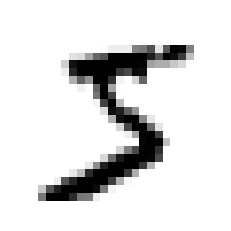

In [8]:
# 2차원 배열로 바꾸지 않으면 이미지를 그릴 수 없다.
image_0 = X[0].reshape(28,28)
plt.imshow(image_0,cmap="binary")
plt.axis("off")
plt.show()

In [ ]:
y = y.astype(np.int8)

In [11]:
#훈련 세트와 테스트 세트 나누기
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]